In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib




In [43]:
df = pd.read_csv("../../data/Salary_Data.csv")
print("Rows after loading:", len(df))

df.dropna(inplace=True)   # Remove missing values
print("Rows after removing missing values:", len(df))

df.drop_duplicates(inplace=True)  # Remove duplicate rows
print("Rows after removing duplicates:", len(df))


Rows after loading: 6704
Rows after removing missing values: 6698
Rows after removing duplicates: 1787


In [44]:
def clean_text(text):
    if isinstance(text, str):
        text = text.strip().lower()
        text = text.replace("’", "'")
        text = text.replace(" degree", "")  # Remove word 'degree'
        text = text.replace("bachelors", "bachelor's")
        text = text.replace("masters", "master's")
        text = text.replace("phd", "phd")
        text = text.title()  # Title case for uniformity
    return text

df['Education Level'] = df['Education Level'].apply(clean_text)
print("Cleaned Education Levels:", df['Education Level'].unique())

# Function to remove outliers using IQR
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df_cleaned = remove_outliers_iqr(df, ['Salary'])
df_cleaned = df_cleaned[df_cleaned['Salary'] > 1000]  # Keep realistic values
df_cleaned = df_cleaned.reset_index(drop=True)
print(f"Original rows: {len(df)}, Cleaned rows: {len(df_cleaned)}")



Cleaned Education Levels: ["Bachelor'S" "Master'S" 'Phd' 'High School']
Original rows: 1787, Cleaned rows: 1783


In [45]:
X = df_cleaned.drop('Salary', axis=1)
y = df_cleaned['Salary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['Gender']
)



In [46]:
# Handle rare categories
threshold = 10
for col in ['Job Title', 'Education Level']:
    top_categories = X_train[col].value_counts().loc[lambda x: x >= threshold].index
    X_train[col] = X_train[col].where(X_train[col].isin(top_categories), 'Other')
    X_test[col] = X_test[col].where(X_test[col].isin(top_categories), 'Other')


# Preprocessing pipeline
numerical_cols = ['Age', 'Years of Experience']
categorical_cols = ['Gender', 'Education Level', 'Job Title']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

# Random Forest model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42
    ))
])
# K-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
print(f"Mean CV R²: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Fit model
model.fit(X_train, y_train)


Mean CV R²: 0.817 (+/- 0.050)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [47]:

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


# Evaluation function
def evaluate_detailed(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"RMSE: LKR {rmse:,.2f}")
    print(f"R²: {r2:.3f}")
    print(f"MAE: LKR {mae:,.2f}")
    
    return rmse, r2, mae

train_metrics = evaluate_detailed(y_train, y_train_pred, "Training")
test_metrics = evaluate_detailed(y_test, y_test_pred, "Testing")





Training Metrics:
RMSE: LKR 19,911.59
R²: 0.849
MAE: LKR 15,371.48

Testing Metrics:
RMSE: LKR 22,220.46
R²: 0.817
MAE: LKR 17,087.81



## Interpretation

- The R² value of 0.817 (test) indicates that the model explains about 81.7% of the variation in employee salaries.  
- The training R² (0.849) and testing R² (0.817) are close, showing that the model generalizes well and is not overfitting.  
- RMSE and MAE values show that the model’s average salary prediction error is approximately ±17,000–22,000 LKR, which is reasonable for this dataset.  
- RMSE being slightly higher than MAE suggests the presence of a few outlier salaries with larger prediction errors.  
- Overall, the Random Forest model demonstrates strong predictive accuracy, stability, and reliable performance across both training and testing sets.  
- The model effectively uses input features such as Age, Years of Experience, Education Level, Gender, and Job Title to estimate salaries accurately.

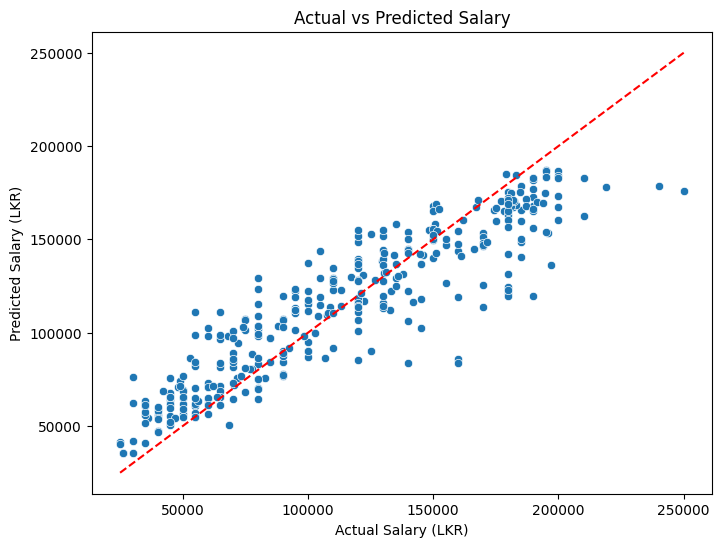

In [48]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Salary (LKR)")
plt.ylabel("Predicted Salary (LKR)")
plt.title("Actual vs Predicted Salary")
plt.show()


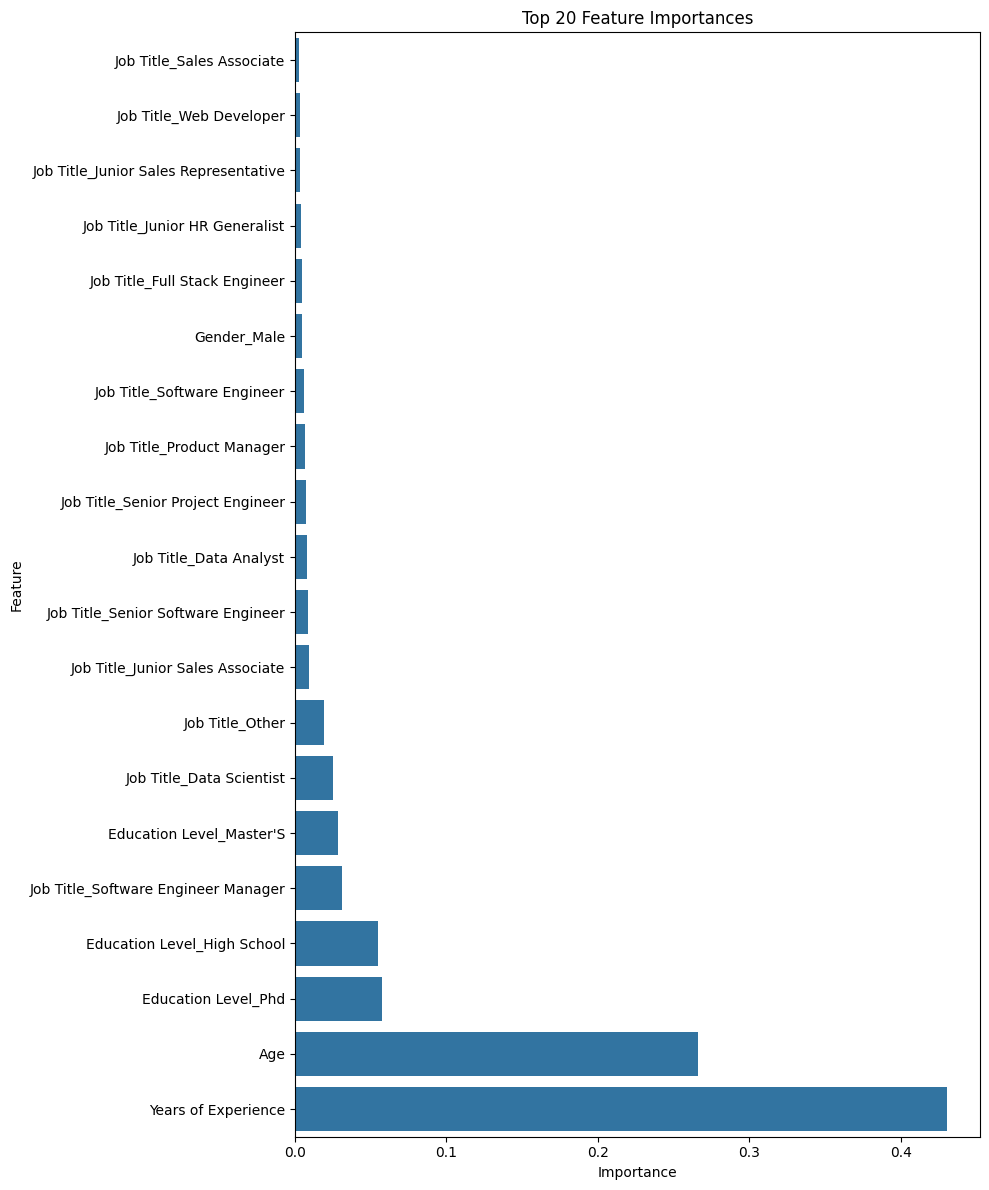

In [49]:
reg = model.named_steps['regressor']
cat_features = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_features)

feat_imp = pd.Series(reg.feature_importances_, index=feature_names).sort_values(ascending=True)
top_n = 20

plt.figure(figsize=(10, 0.5 * top_n + 2))
sns.barplot(x=feat_imp.values[-top_n:], y=feat_imp.index[-top_n:])
plt.title(f"Top {top_n} Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [50]:
new_employee = pd.DataFrame({
    'Age': [30],
    'Years of Experience': [5],
    'Gender': ['Male'],
    'Education Level': ['Bachelor'],
    'Job Title': ['Data Analyst']
})

predicted_salary = model.predict(new_employee)[0]
print(f"\nPredicted Salary for the new employee: LKR {predicted_salary:,.2f}")


Predicted Salary for the new employee: LKR 106,421.80


/opt/conda/envs/ml-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [51]:
joblib.dump(model, "Random_Forest_salary_model.pkl")
print("\nModel saved as Random_Forest_salary_model.pkl")


Model saved as Random_Forest_salary_model.pkl
